In [ ]:
#Install textstat
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.1 MB/s eta 0:00:00


In [ ]:
#Import packages

#Basic data analysis
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_1samp

#TextBlob Tools
from textblob import TextBlob
from nltk.tokenize import BlanklineTokenizer

#TextStat Tools
from textstat import textstat

#Clustering and visualization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import rcParams

#Clustering optimization
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer


In [ ]:
#Open and Read BILD 4 Manual
file_path = '/content/finalBILD4tokenizedmanual.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()
    file_content = ''.join(lines)

In [ ]:
#Clean
chunks = [c for c in file_content.split('****************') if c]
filtered_chunks = list(filter(lambda x: x != '\n', chunks))
filtered_chunks = filtered_chunks[3:]
filtered_chunks = [c.strip() for c in filtered_chunks]

filtered_lines = [c.split("\n") for c in filtered_chunks]
filtered_lines = [item for sublist in filtered_lines for item in sublist]
filtered_lines = [item for item in filtered_lines if item != '']
filtered_lines = [l.strip() for l in filtered_lines]
lines_series = pd.Series(filtered_lines)

data_chunks = [c.strip() for c in filtered_chunks]
data_chunks = [c.replace('\n', ' ') for c in data_chunks]
data_chunks = [c.replace('\n ', ' ') for c in data_chunks]
data_chunks = [c.replace(' \n', ' ') for c in data_chunks]
data_chunks = [c.replace('   ', ' ') for c in data_chunks]
data_chunks = [c.replace('  ', ' ') for c in data_chunks]

result_cols = ['Sentence', 'Section', 'Label', 'Polarity', 'Subjectivity', 'Reading_Ease', 'Average_Reading_Time']
chunk_results = pd.DataFrame(columns=result_cols)
for chunk in data_chunks:
    section = chunk[1:3]
    label = chunk[:5]
    result_list = [[chunk[6:]], [section], [label], [TextBlob(chunk[6:]).sentiment[0]], [TextBlob(chunk[6:]).sentiment[1]], textstat.flesch_reading_ease(chunk[6:]), textstat.reading_time(chunk[6:])/len(chunk[6:])]
    result_row  = dict(zip(result_cols, result_list))
    real_result_row = pd.DataFrame(result_row)
    chunk_results = pd.concat([chunk_results, real_result_row], axis = 0, ignore_index = True)
    chunk_results.reset_index()
chunk_results.reset_index()

<Axes: xlabel='Polarity', ylabel='Subjectivity'>

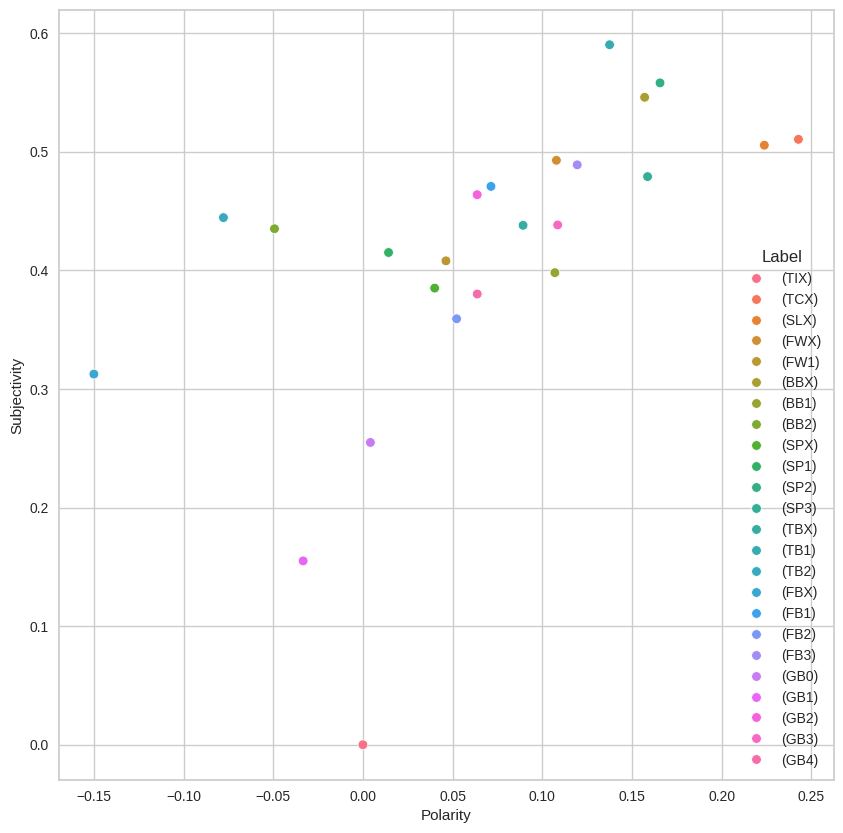

In [ ]:
rcParams['figure.figsize'] = 10,10
sns.scatterplot(data=chunk_results, x='Polarity', y='Subjectivity', hue='Label')

In [ ]:
#Vectorize data using TFIDF matrix for unsupervised clustering
vectorizer = TfidfVectorizer(stop_words='english')
vectorized_lines = vectorizer.fit_transform(lines_series)
pca = PCA(n_components=2)
pca_lines = pca.fit_transform(vectorized_lines.toarray())

2,  0.013069405901679194
3,  0.015702368394045943
4,  0.01161253734048385
5,  0.020367653036579673
6,  0.021797640117030146
7,  0.02372469432985117
8,  0.026294019117980915
9,  0.026749901086169786
10,  0.029141957763651447
11,  0.031077318833881755
12,  0.03454318499407625
13,  0.032202328709131194
14,  0.03483577685625179
15,  0.03925702543412479
16,  0.04235090629396536
17,  0.04126605108131443
18,  0.04569439838733236
19,  0.04266308594406346
20,  0.04832568070043984


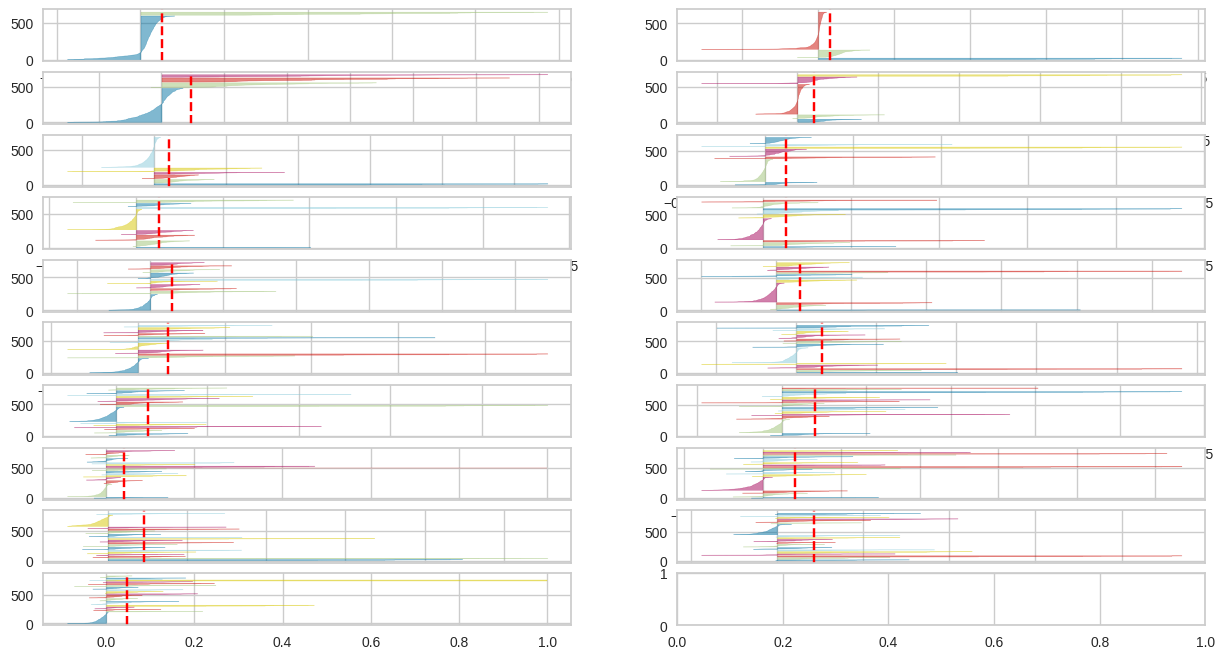

In [ ]:
#Create silhouette plots to determine appropriate cluster number
fig, ax = plt.subplots(10, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(vectorized_lines)
    print(str(i) + ",  " + str(visualizer.silhouette_score_))

                                                  line  Cluster
88   Overview and Background: The success of the BI...        4
6                                     (FWX) Field Work        4
260                              Part 2: Data Analysis       10
372     Increase your proficiency with Microsoft Excel       10
434                 a. Make a copy of your Excel file.       10


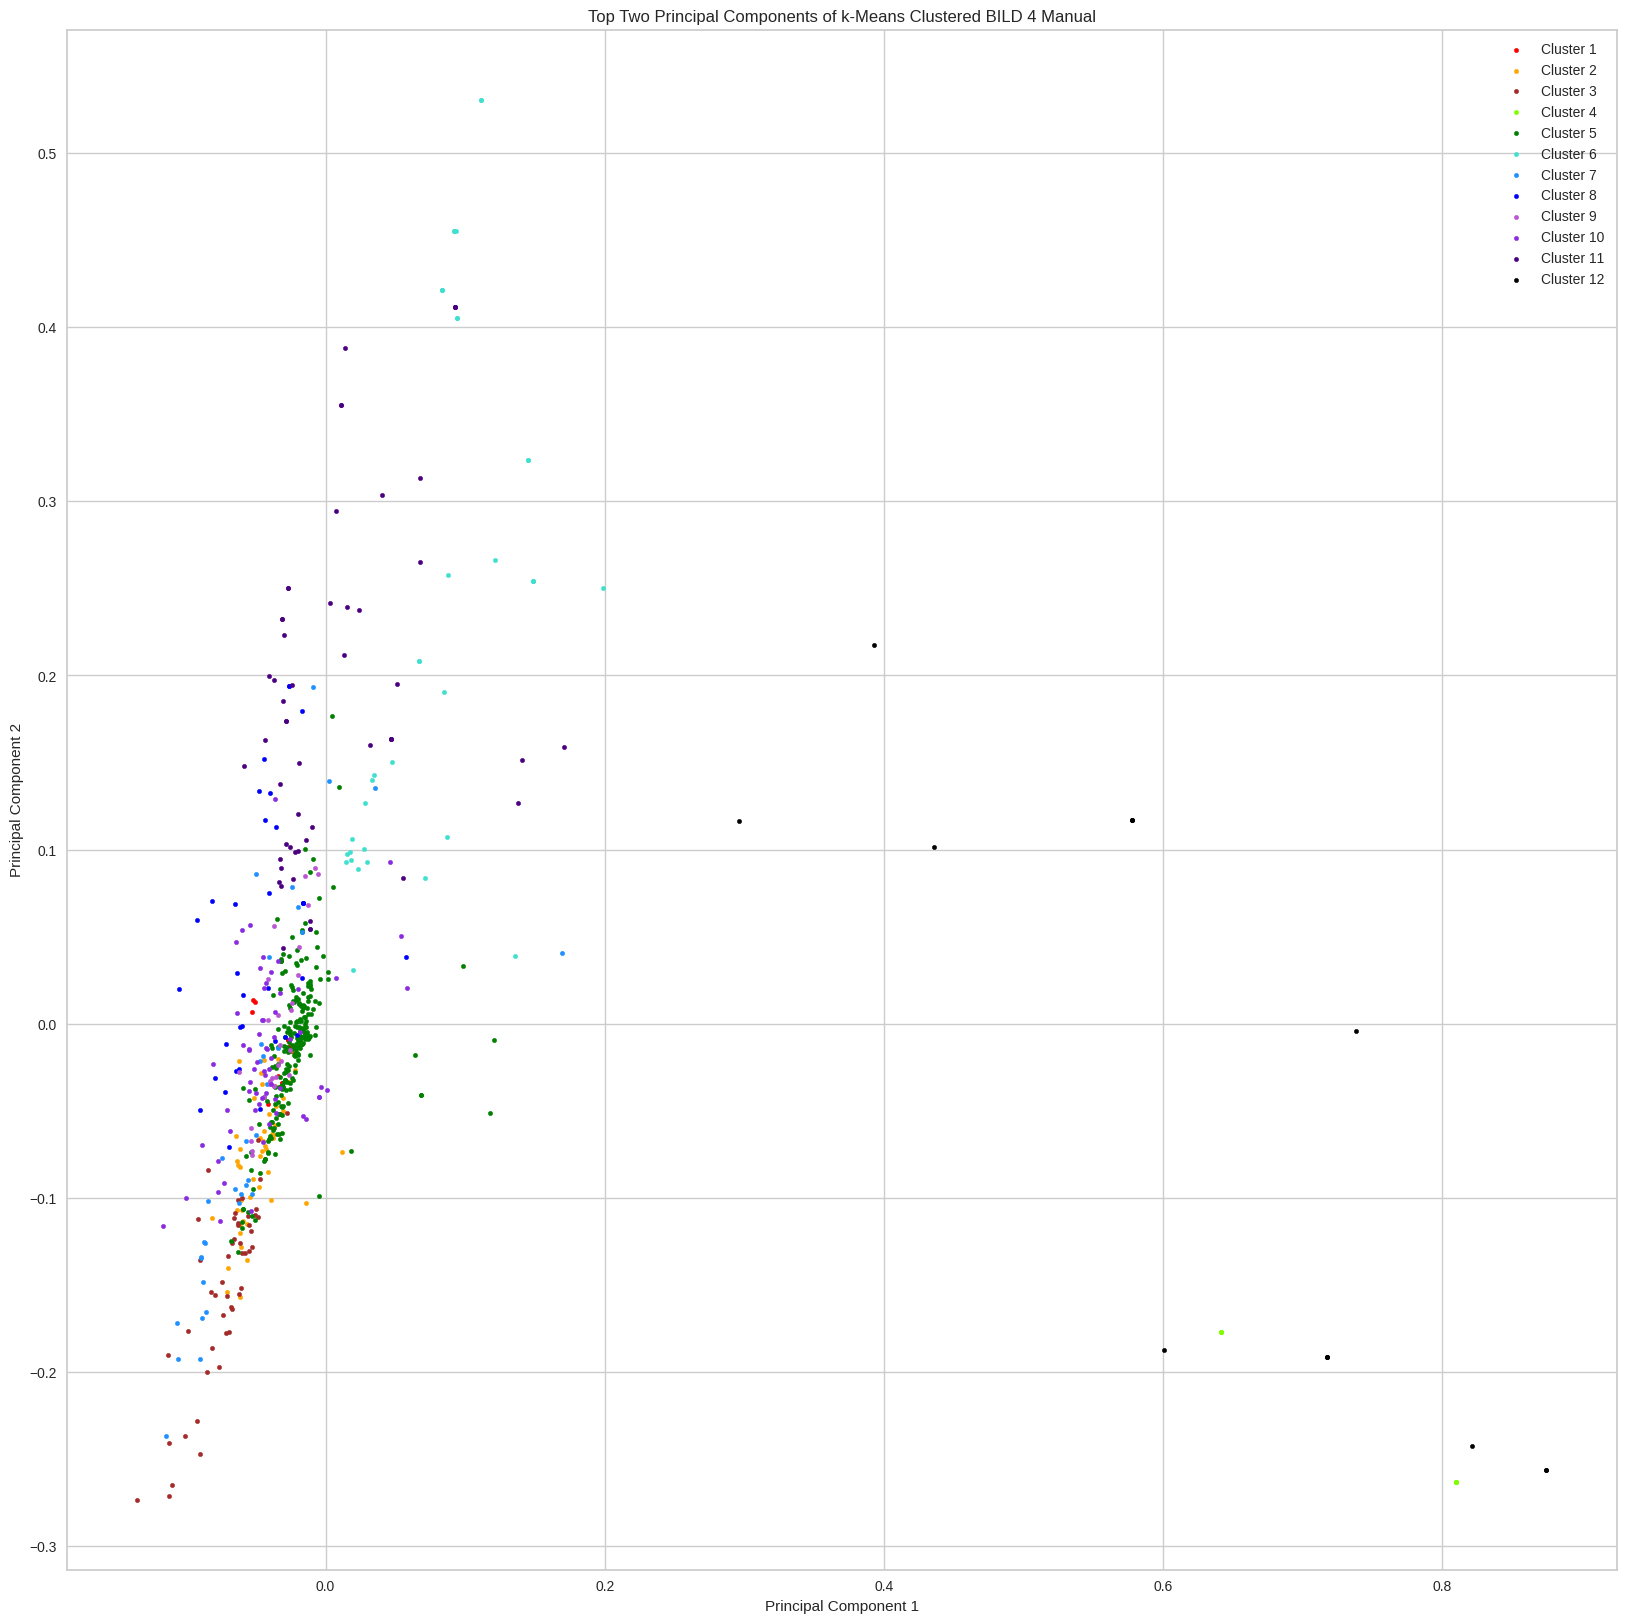

In [ ]:
#Plot PCA plot of k-means clusters

num_clusters = 12
kmeans = KMeans(n_clusters=num_clusters, n_init=5,
                max_iter=500, random_state=42)
kmeans.fit(vectorized_lines)


# create a dataframe to store the results
kmeans_results = pd.DataFrame()
kmeans_results['line'] = lines_series
kmeans_results['Cluster'] = kmeans.labels_

# print the results
print(kmeans_results.sample(5))

# plot the results
colors = ['red', 'orange','brown','chartreuse','green','turquoise','dodgerblue','blue','mediumorchid','blueviolet','indigo','black']
cluster = ['1', '2','3','4','5','6','7','8','9','10','11','12']
for i in range(num_clusters):
    plt.scatter(pca_lines[kmeans.labels_ == i, 0],
                pca_lines[kmeans.labels_ == i, 1],
                s=10
                , color=colors[i],
                label=f'Cluster {cluster[i]}'
                )
plt.legend()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Top Two Principal Components of k-Means Clustered BILD 4 Manual")
plt.show()

In [ ]:
#Process and add in k-means clustered data
kmeans_results
kmeans_results_2 = kmeans_results[~kmeans_results['line'].str.startswith('(')]
kmeans_results_2 = kmeans_results_2[kmeans_results_2['line'] != '']

In [ ]:
#Apply text scoring metrics to completed dataset
def polarity(line):
    return TextBlob(line).sentiment[0]

def subjectivity(line):
    return TextBlob(line).sentiment[1]

def reading_ease(line):
    return textstat.flesch_reading_ease(line)

def reading_time(line):
    return textstat.reading_time(line)/(len(line)+0.00001)

kmeans_results_2['Polarity'] = kmeans_results['line'].apply(polarity)
kmeans_results_2['Subjectivity'] = kmeans_results['line'].apply(subjectivity)
kmeans_results_2['Flesch Reading Ease'] = kmeans_results['line'].apply(reading_ease)
kmeans_results_2['Per Character Reading Time (s)'] = kmeans_results['line'].apply(reading_time)

In [ ]:
#Calculate p-values
#Columns can be edited to obtain desired p-values

t_statistic, p_value = ttest_1samp(kmeans_results_2["Per Character Reading Time (s)"], 0.01469)

0.0

(0.0, 100.0)

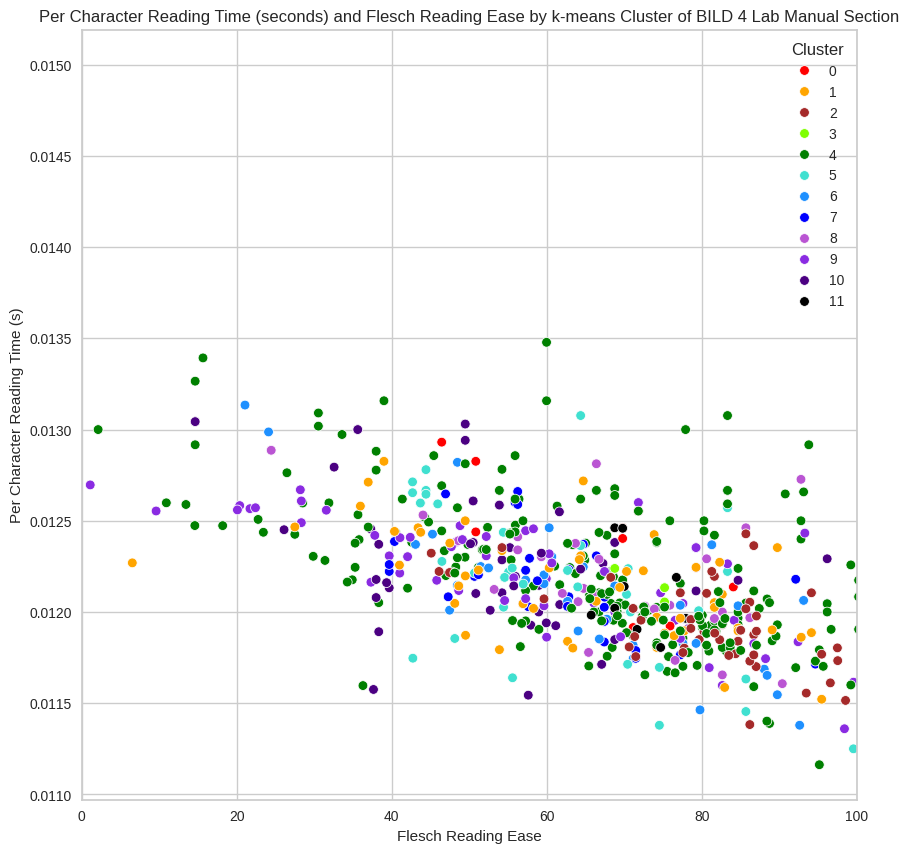

In [ ]:
#Create plots
#Columns can be edited to obtain desired plots

rcParams['figure.figsize'] = 10,10
a = sns.scatterplot(data=kmeans_results_2, x='Flesch Reading Ease', y='Per Character Reading Time (s)', hue='Cluster', palette=['red', 'orange','brown','chartreuse','green','turquoise','dodgerblue','blue','mediumorchid','blueviolet','indigo','black'])
plt.title("Per Character Reading Time (seconds) and Flesch Reading Ease by k-means Cluster of BILD 4 Lab Manual Section")
plt.xlim(0,100)

In [ ]:
#Categorize data based on lab manual subheadings
result_cols =  ['Sentence', 'Section', 'Procedure', 'Polarity', 'Subjectivity', 'Flesch Reading Ease', 'Per Character Reading Time (s)']
results = pd.DataFrame(columns=result_cols)
for chunk in filtered_chunks:
    lines = [l for l in chunk.split('\n') if l]
    label = lines[0]
    section = label[1:3]
    lines = lines[1:]
    for line in lines:
        result_list = [[line], [section], [label], [TextBlob(line).sentiment[0]], [TextBlob(line).sentiment[1]], textstat.flesch_reading_ease(line), textstat.reading_time(line)/len(line)]
        result_row  = dict(zip(result_cols, result_list))
        real_result_row = pd.DataFrame(result_row)
        results = pd.concat([results, real_result_row], axis = 0, ignore_index = True)
        results.reset_index()
results.reset_index()

,index,Sentence,Section,Procedure,Polarity,Subjectivity,Flesch Reading Ease,Per Character Reading Time (s)
0,0,"Throughout the course, you will be using one o...",SL,(SLX) Scientific Literature,0.250000,0.750000,44.24,0.012423
1,1,"Primary Research Articles, Secondary Review Ar...",SL,(SLX) Scientific Literature,0.175000,0.610000,18.18,0.012473
2,2,An editor at the journal will decide if they t...,SL,(SLX) Scientific Literature,0.226852,0.370370,46.98,0.012159
3,3,Another type of article provides an overview o...,SL,(SLX) Scientific Literature,0.166786,0.378532,34.90,0.012176
4,4,Popular Science Articles: Unlike primary rese...,SL,(SLX) Scientific Literature,0.280208,0.617708,14.59,0.012474
...,...,...,...,...,...,...,...,...
614,614,18. Enter the cleaned up DNA concentrations (n...,GB,(GB5) Purification of 16S PCR Product,0.000000,0.000000,64.71,0.012718
615,615,This liquid level should be high enough to con...,GB,(GB5) Purification of 16S PCR Product,0.080000,0.520000,87.05,0.011818
616,616,The DNA will now separate from the magnetic beads,GB,(GB5) Purification of 16S PCR Product,0.000000,0.000000,79.26,0.012245
617,617,"Do not throw this away, this is your cleaned u...",GB,(GB5) Purification of 16S PCR Product,0.000000,0.000000,111.07,0.011923


Text(0.5, 1.0, 'Subjectivity and Polarity by BILD 4 Lab Manual Section')

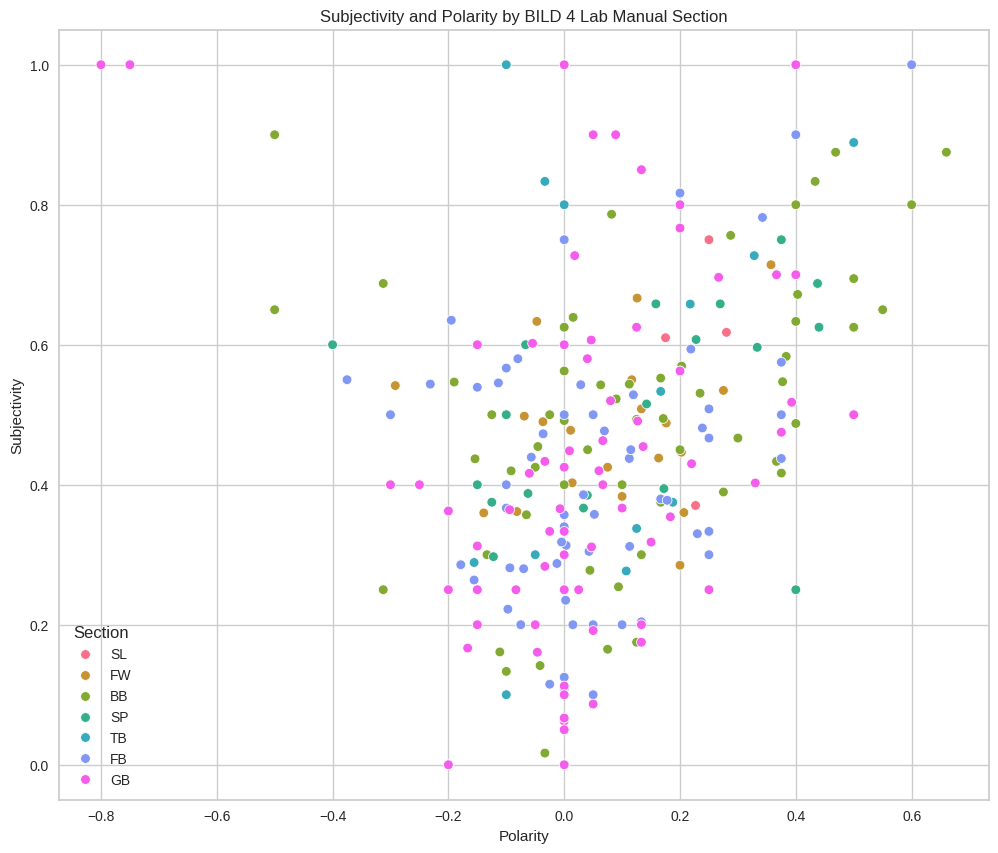

In [ ]:
#Create plots
rcParams['figure.figsize'] = 12,10
plot = sns.scatterplot(data=results, x='Polarity', y='Subjectivity', hue='Section')
plt.title("Subjectivity and Polarity by BILD 4 Lab Manual Section")

In [ ]:
#Edit labels for cleaner plots
results["Group_Label"] = results["Label"].str[1:3]

<Axes: xlabel='Polarity', ylabel='Subjectivity'>

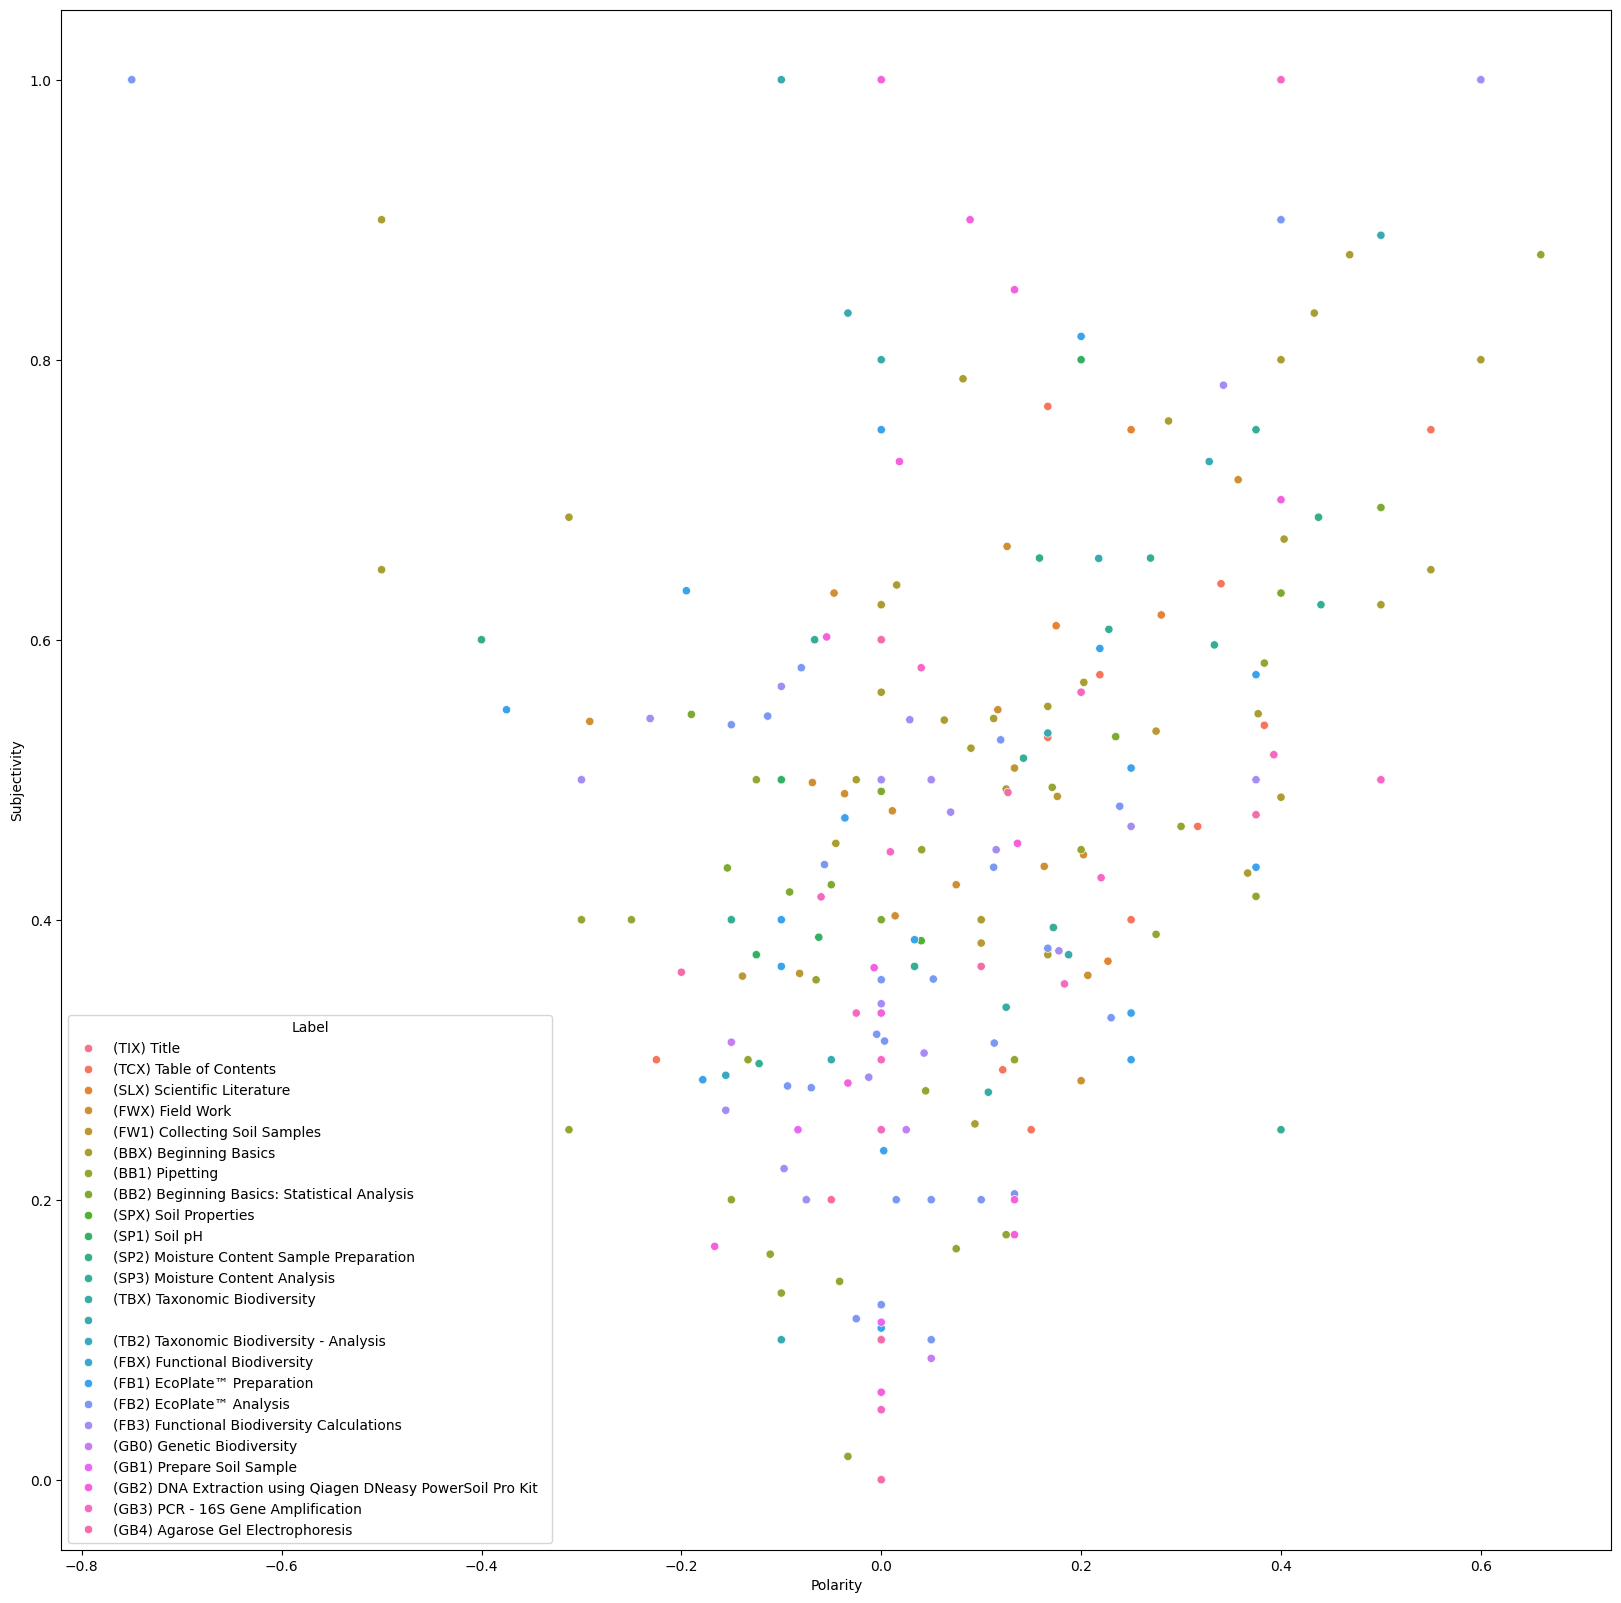

In [ ]:
#Continued plots
rcParams['figure.figsize'] = 20,20
sns.scatterplot(data=results, x='Polarity', y='Subjectivity', hue='Label')

<Axes: xlabel='Polarity', ylabel='Subjectivity'>

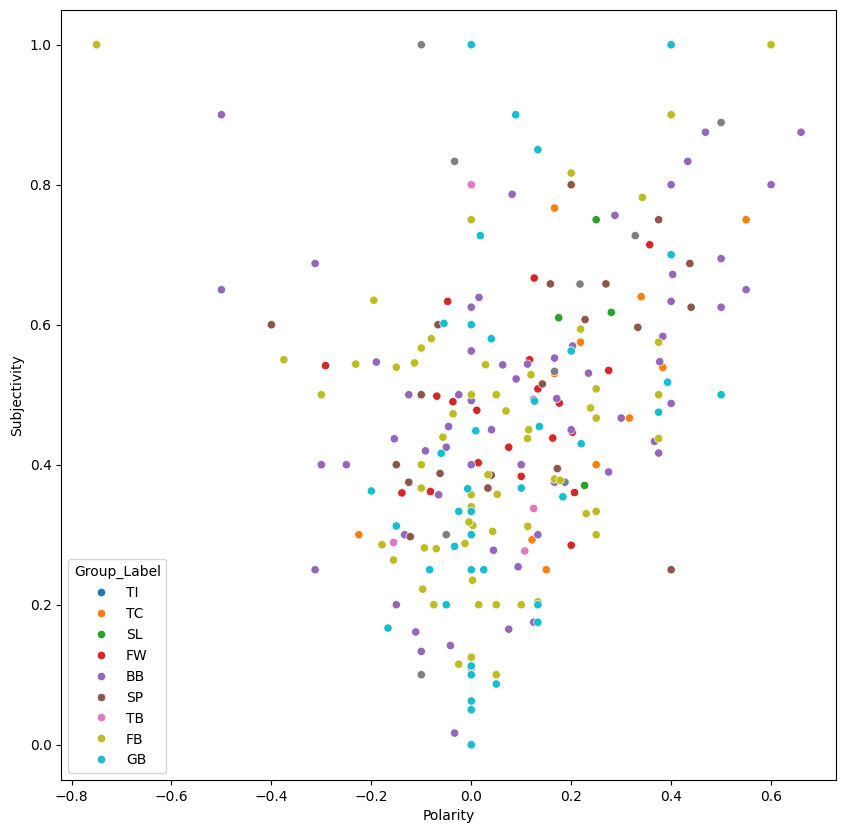

In [ ]:
#Continued plots
rcParams['figure.figsize'] = 10,10
sns.scatterplot(data=results, x='Polarity', y='Subjectivity', hue='Group_Label')